In [1]:
import numpy as np
from astropy.io import fits
import healpy as hp
import pymaster as nm 
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u

# This notebook is trying to figure out what is going on with the maps and normalization

In [2]:
def select_regressis_DES(ra, dec):    
    '''
    input_array with RA, DEC given by ra_col,dec_col
    return selection for DES as defined by regressis
    '''

    from regressis import footprint
    import healpy as hp
    foot = footprint.DR9Footprint(2048, mask_lmc=False, clear_south=True, mask_around_des=False, cut_desi=False)
    north, south, des = foot.get_imaging_surveys()
    th,phi = (-dec+90.)*np.pi/180.,ra*np.pi/180.
    pix = hp.ang2pix(2048,th,phi,nest=True)
    sel_des = des[pix]
    return sel_des

In [3]:
def cut_to_region_and_zrange(fname_NGC, fname_SGC, version='v1.5', zmin=0.80, zmax=3.10, region='N', 
                           weight_opt='default_addLIN', nside=2048, comp=0.00, coord='galactic'):
    data_file1 = fits.open(fname_NGC)[1].data
    data_file2 = fits.open(fname_SGC)[1].data

    if (region == 'NGC') or (region == 'S_NGC'):
        ra = data_file1['RA']
        dec = data_file1['DEC']
        z = data_file1['Z']
        weight = data_file1['WEIGHT']
        weight_sys = data_file1['WEIGHT_SYS']
        photsys = data_file1['PHOTSYS']
        targetid = data_file1['TARGETID']
    elif (region == 'SGC') or (region == 'S_SGC-noDES') or (region == 'DES'):
        ra = data_file2['RA']
        dec = data_file2['DEC']
        z = data_file2['Z']
        weight = data_file2['WEIGHT']
        weight_sys = data_file2['WEIGHT_SYS']
        photsys = data_file2['PHOTSYS']
        targetid = data_file2['TARGETID']
    else:
        ra = np.concatenate((data_file1['RA'], data_file2['RA']))
        dec = np.concatenate((data_file1['DEC'], data_file2['DEC']))
        z = np.concatenate((data_file1['Z'], data_file2['Z']))
        weight = np.concatenate((data_file1['WEIGHT'], data_file2['WEIGHT']))
        weight_sys = np.concatenate((data_file1['WEIGHT_SYS'], data_file2['WEIGHT_SYS']))
        photsys = np.concatenate((data_file1['PHOTSYS'], data_file2['PHOTSYS']))
        targetid = np.concatenate((data_file1['TARGETID'], data_file2['TARGETID']))

    # Redshift cut
    print('length before zcut', np.shape(ra)[-1])
    len_before_cut = np.shape(ra)[-1]
    ra = ra[(z >= zmin) & (z <= zmax)]
    dec = dec[(z >= zmin) & (z <= zmax)]
    weight = weight[(z >= zmin) & (z <= zmax)]
    weight_sys = weight_sys[(z >= zmin) & (z <= zmax)]
    photsys = photsys[(z >= zmin) & (z <= zmax)]
    targetid = targetid[(z >= zmin) & (z <= zmax)]
    z = z[(z >= zmin) & (z <= zmax)]
    print('length after zcut', np.shape(ra)[-1])
    len_after_cut = np.shape(ra)[-1]
    norm_fac = len_after_cut / len_before_cut

    # Hemisphere cut
    if (region == 'N') or (region == 'S') or (region == 'S_NGC'):
        # Handle Northern and Southern hemisphere cuts
        if (region == 'N') or (region == 'S'):
            regsel = region
        elif region == 'S_NGC':
            regsel = 'S'

        # Filter data based on the photometric system
        ra = ra[photsys == regsel]
        dec = dec[photsys == regsel]
        weight = weight[photsys == regsel]
        weight_sys = weight_sys[photsys == regsel]
        z = z[photsys == regsel]
        targetid = targetid[photsys == regsel]
        photsys = photsys[photsys == regsel]

    elif region == 'DES':
        # Select data within the DES region
        is_DES_dat = select_regressis_DES(ra, dec)

        ra = ra[is_DES_dat]
        dec = dec[is_DES_dat]
        weight = weight[is_DES_dat]
        weight_sys = weight_sys[is_DES_dat]
        z = z[is_DES_dat]
        photsys = photsys[is_DES_dat]
        targetid = targetid[is_DES_dat]

    elif region == 'S_SGC-noDES':
        # Filter out DES data specifically from the Southern region
        is_DES_dat = select_regressis_DES(ra, dec)

        # Apply both 'S' (Southern) and not in DES filters
        mask = (photsys == 'S') & (~is_DES_dat)
        ra = ra[mask]
        dec = dec[mask]
        weight = weight[mask]
        weight_sys = weight_sys[mask]
        z = z[mask]
        photsys = photsys[mask]
        targetid = targetid[mask]

    full = fits.open('/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/%s/QSO_full_HPmapcut.dat.fits' % version)[1].data
    if weight_opt == 'default':
        weight = weight / weight_sys

    elif weight_opt == 'default_addLIN':
        targetid_as = np.argsort(full['TARGETID'])
        full_inds = np.searchsorted(full['TARGETID'][targetid_as], targetid)
        weight_lin = full[targetid_as][full_inds]['WEIGHT_IMLIN']
        weight = weight * weight_lin / weight_sys

    elif weight_opt == 'default_addRF':
        targetid_as = np.argsort(full['TARGETID'])
        full_inds = np.searchsorted(full['TARGETID'][targetid_as], targetid)
        weight_rf = full[targetid_as][full_inds]['WEIGHT_RF']
        weight = weight * weight_rf / weight_sys

    return ra, dec, weight, weight_sys, z, photsys, targetid, norm_fac


In [4]:
version = 'v1.5'
N = cut_to_region_and_zrange('/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/%s/QSO_NGC_clustering.dat.fits' % version,
		'/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/%s/QSO_SGC_clustering.dat.fits' % version, region="N")
S = cut_to_region_and_zrange('/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/%s/QSO_NGC_clustering.dat.fits' % version,
		'/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/%s/QSO_SGC_clustering.dat.fits' % version, region="S")
S_NGC = cut_to_region_and_zrange('/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/%s/QSO_NGC_clustering.dat.fits' % version,
		'/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/%s/QSO_SGC_clustering.dat.fits' % version, region="S_NGC")
DES = cut_to_region_and_zrange('/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/%s/QSO_NGC_clustering.dat.fits' % version,
		'/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/%s/QSO_SGC_clustering.dat.fits' % version, region="DES")
S_SGC_noDES = cut_to_region_and_zrange('/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/%s/QSO_NGC_clustering.dat.fits' % version,
		'/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/%s/QSO_SGC_clustering.dat.fits' % version, region="S_SGC-noDES")

length before zcut 1223391
length after zcut 1190839
length before zcut 1223391
length after zcut 1190839
length before zcut 793219
length after zcut 772215
length before zcut 430172
length after zcut 418624
length before zcut 430172
length after zcut 418624


In [5]:
labels = ['ra', 'dec', 'weight', 'weight_sys', 'z', 'photsys', 'targetid', 'norm_fac']

# N

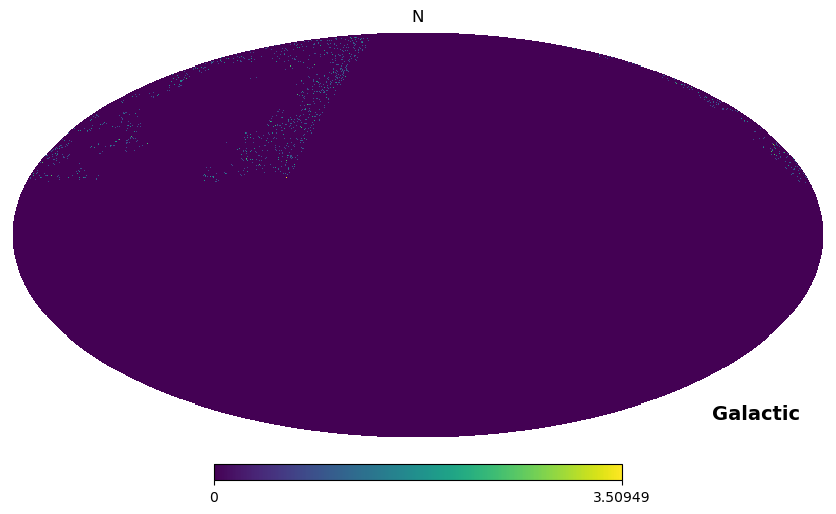

In [5]:
nside = 2048
coords = SkyCoord(ra=N[0]*u.deg,dec=N[1]*u.deg)
pix = hp.ang2pix(nside, coords.galactic.l.value, coords.galactic.b.value, lonlat=True)
data_map = np.bincount(pix, minlength=12*nside**2, weights=N[2])
hp.mollview(data_map, title='N', coord="G")

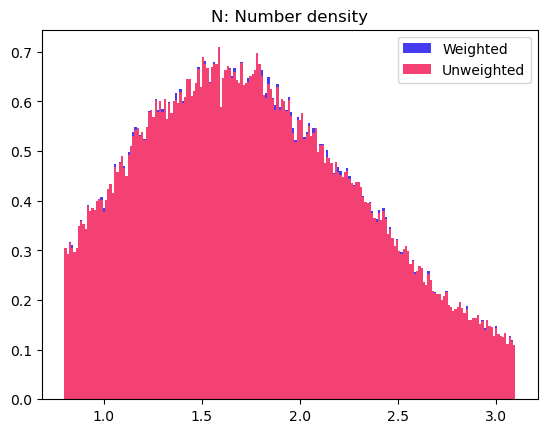

In [6]:
plt.hist(N[4], bins=200, weights=N[2], label = "Weighted", color = "#473BF0", density = True)
plt.hist(N[4], bins=200, label = "Unweighted", color = "#F44174", density=True)
plt.title("N: Number density")
plt.legend();

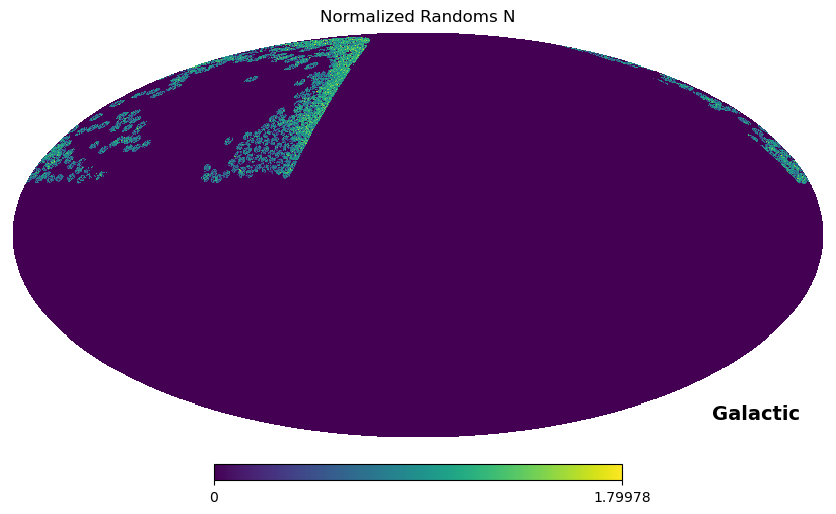

In [7]:
file = 'QSO_maps/QSO_z0.80_3.10_N__HPmapcut_default_addLIN_nside2048_v1.5_comp0.00_galactic_RAN_MAP.fits'
rand_N = hp.read_map(file)
N_mean = np.loadtxt('QSO_maps/QSO_z0.80_3.10_N__HPmapcut_default_addLIN_nside2048_v1.5_comp0.00_galactic_ran_mean.txt')
hp.mollview(rand_N/N_mean, title='Normalized Randoms N', coord="G")

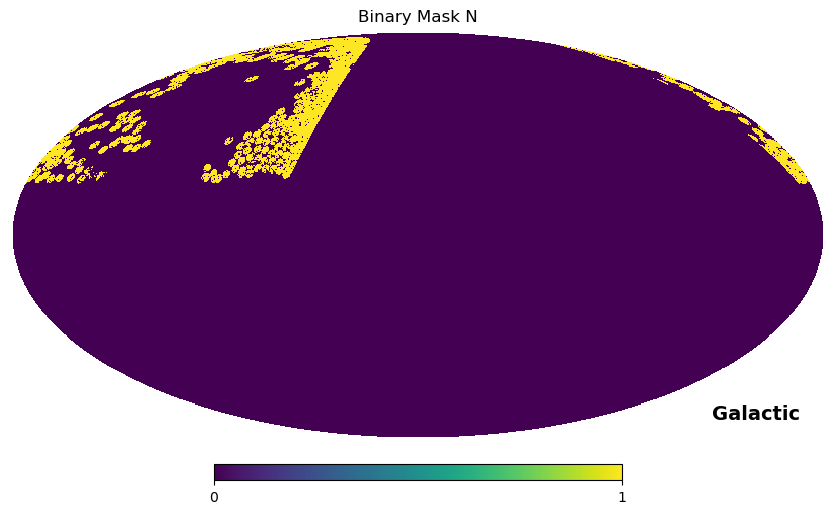

In [8]:
file = 'QSO_maps/QSO_z0.80_3.10_N__HPmapcut_default_addLIN_nside2048_v1.5_comp0.00_galactic_BINARY_MASK.fits'
bin_N = hp.read_map(file)
hp.mollview(bin_N, title='Binary Mask N', coord="G")

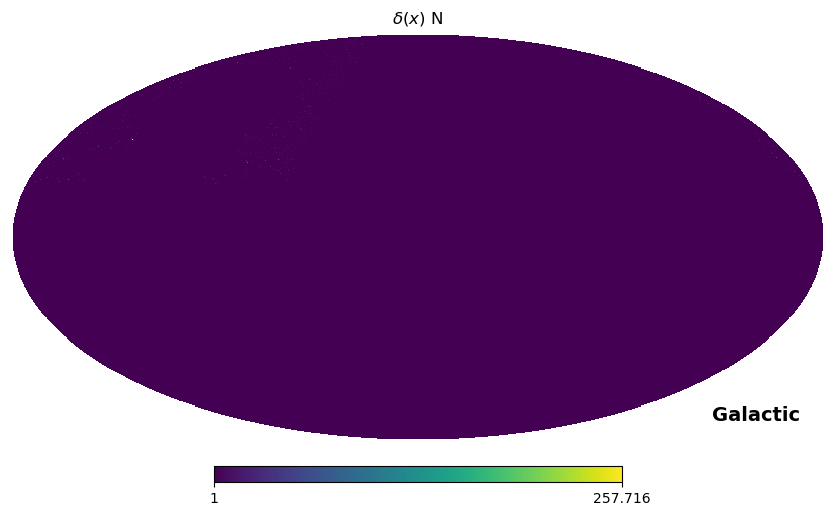

In [9]:
file = 'QSO_maps/QSO_z0.80_3.10_N__HPmapcut_default_addLIN_nside2048_v1.5_comp0.00_galactic_DELTA_MAP.fits'
delta_N = hp.read_map(file)
hp.mollview(delta_N, title=r'$\delta(x)$ N', coord="G", min = 1)

# S

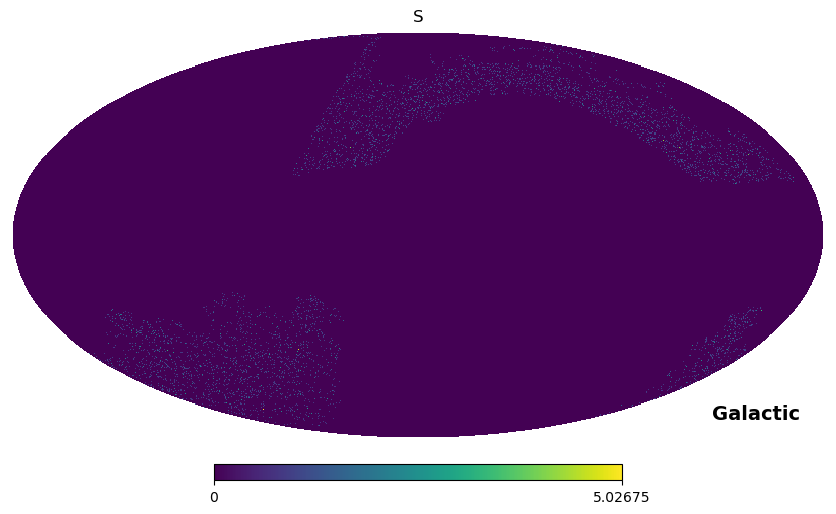

In [10]:
nside = 2048
coords = SkyCoord(ra=S[0]*u.deg,dec=S[1]*u.deg)
pix = hp.ang2pix(nside, coords.galactic.l.value, coords.galactic.b.value, lonlat=True)
data_map_S = np.bincount(pix, minlength=12*nside**2, weights=S[2])
hp.mollview(data_map_S, title='S', coord="G")

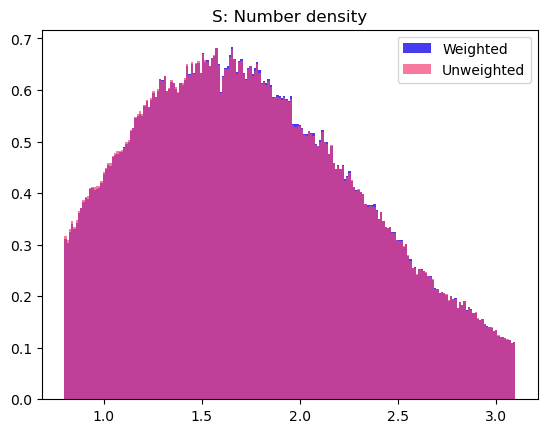

In [11]:
plt.hist(S[4], bins=200, weights=S[2], label = "Weighted", color = "#473BF0", density = True)
plt.hist(S[4], bins=200, label = "Unweighted", color = "#F44174", alpha = 0.7, density=True)
plt.title("S: Number density")
plt.legend();

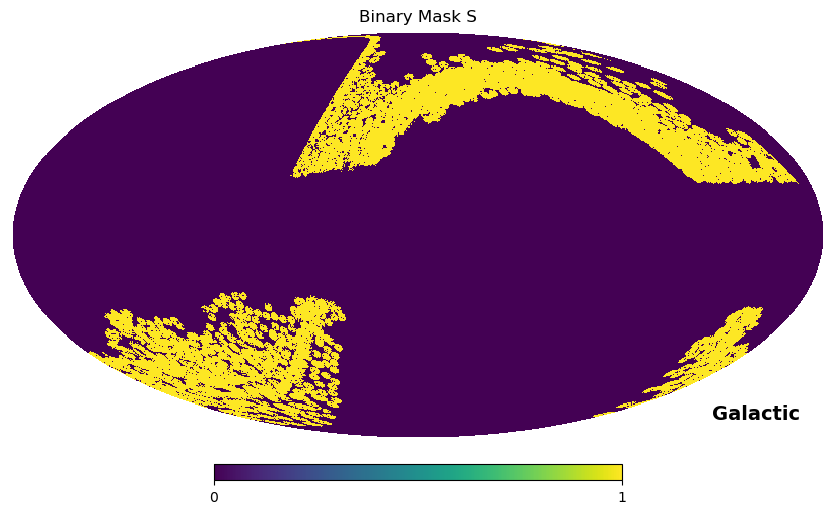

In [12]:
file = 'QSO_maps/QSO_z0.80_3.10_S__HPmapcut_default_addLIN_nside2048_v1.5_comp0.00_galactic_BINARY_MASK.fits'
bin_S = hp.read_map(file)
hp.mollview(bin_S, title='Binary Mask S', coord="G")

# S_NGC

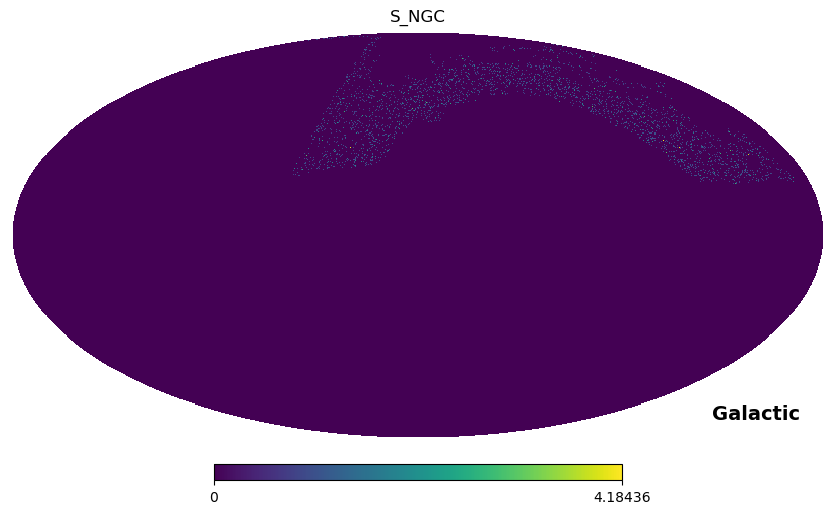

In [13]:
nside = 2048
coords = SkyCoord(ra=S_NGC[0]*u.deg,dec=S_NGC[1]*u.deg)
pix = hp.ang2pix(nside, coords.galactic.l.value, coords.galactic.b.value, lonlat=True)
data_map_S_NGC = np.bincount(pix, minlength=12*nside**2, weights=S_NGC[2])
hp.mollview(data_map_S_NGC, title='S_NGC', coord="G")

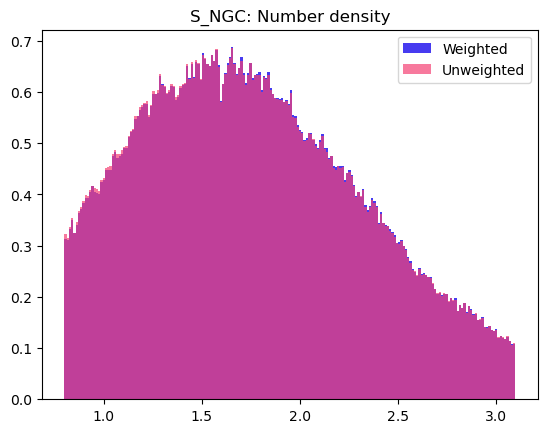

In [14]:
plt.hist(S_NGC[4], bins=200, weights=S_NGC[2], label = "Weighted", color = "#473BF0", density = True)
plt.hist(S_NGC[4], bins=200, label = "Unweighted", color = "#F44174", alpha = 0.7, density=True)
plt.title("S_NGC: Number density")
plt.legend();

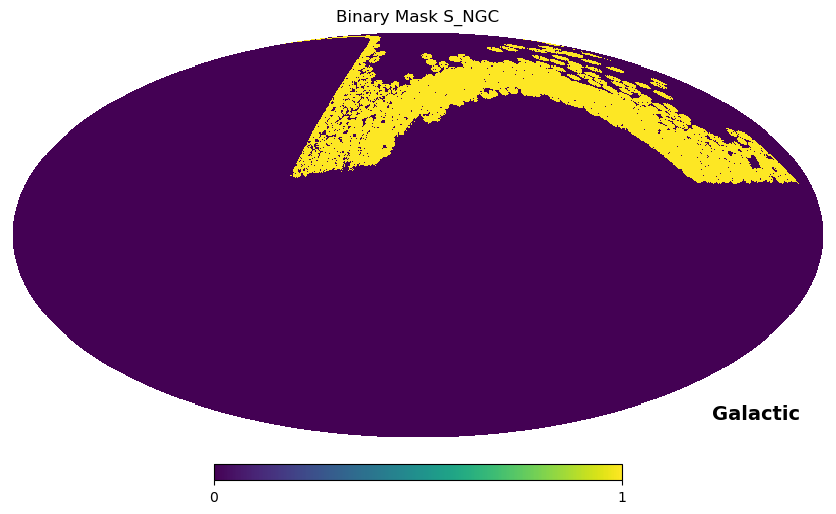

In [15]:
file = 'QSO_maps/QSO_z0.80_3.10_S_NGC__HPmapcut_default_addLIN_nside2048_v1.5_comp0.00_galactic_BINARY_MASK.fits'
bin_S_NGC = hp.read_map(file)
hp.mollview(bin_S_NGC, title='Binary Mask S_NGC', coord="G")

# DES

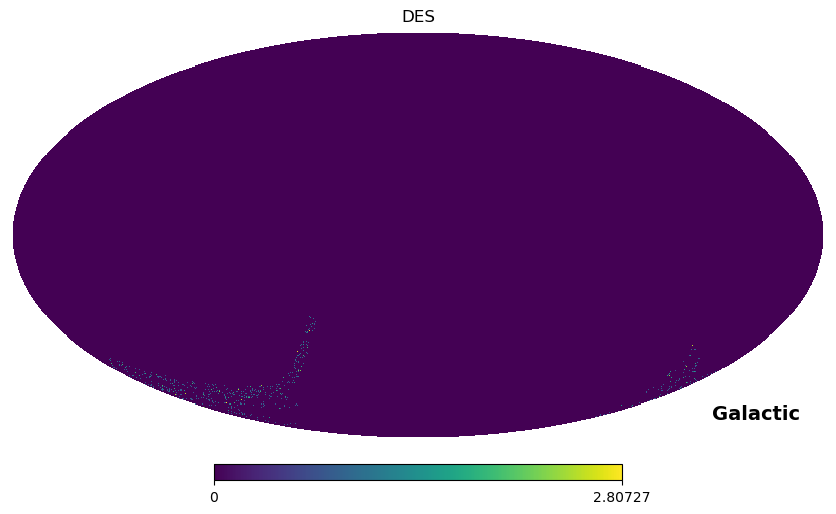

In [16]:
nside = 2048
coords = SkyCoord(ra=DES[0]*u.deg,dec=DES[1]*u.deg)
pix = hp.ang2pix(nside, coords.galactic.l.value, coords.galactic.b.value, lonlat=True)
data_map_DES = np.bincount(pix, minlength=12*nside**2, weights=DES[2])
hp.mollview(data_map_DES, title='DES', coord="G")

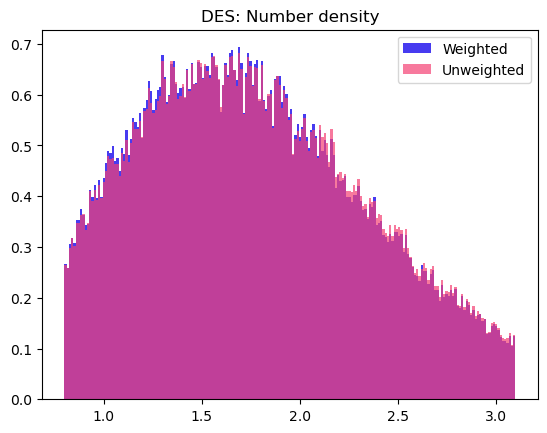

In [17]:
plt.hist(DES[4], bins=200, weights=DES[2], label = "Weighted", color = "#473BF0", density = True)
plt.hist(DES[4], bins=200, label = "Unweighted", color = "#F44174",alpha=0.7, density=True)
plt.title("DES: Number density")
plt.legend();

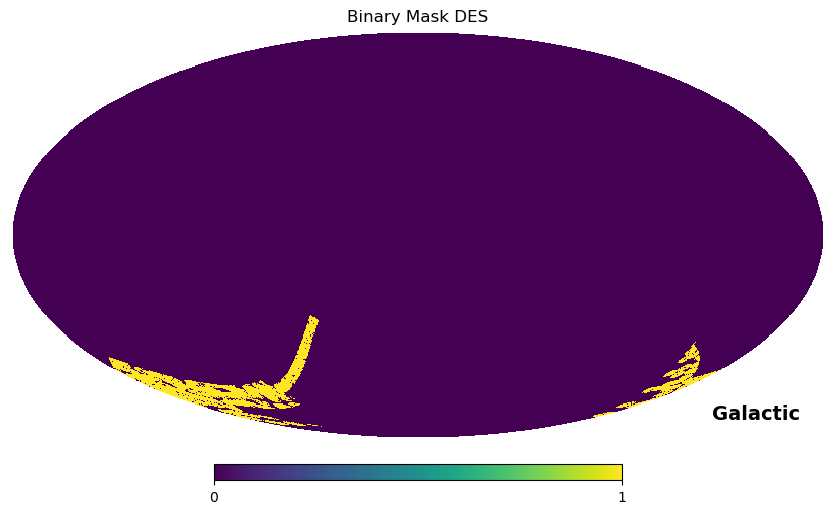

In [18]:
file = 'QSO_maps/QSO_z0.80_3.10_DES__HPmapcut_default_addLIN_nside2048_v1.5_comp0.00_galactic_BINARY_MASK.fits'
bin_DES = hp.read_map(file)
hp.mollview(bin_DES, title='Binary Mask DES', coord="G")

# S_SGC_noDES

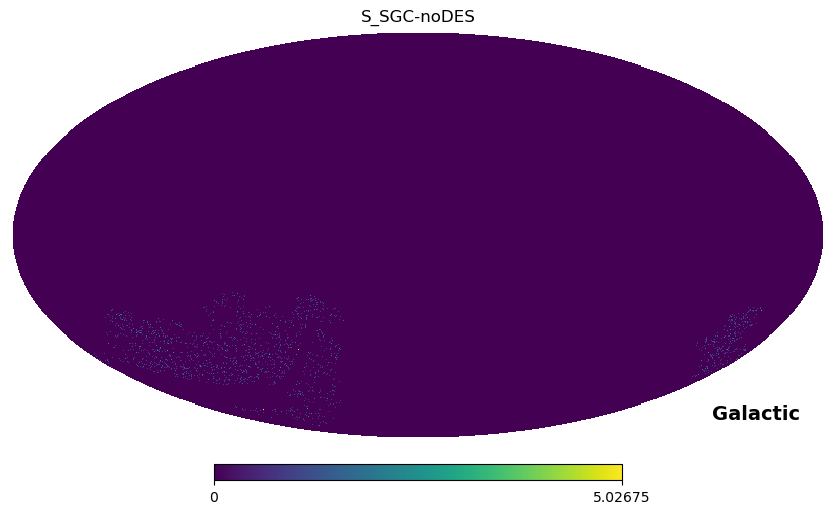

In [19]:
nside = 2048
coords = SkyCoord(ra=S_SGC_noDES[0]*u.deg,dec=S_SGC_noDES[1]*u.deg)
pix = hp.ang2pix(nside, coords.galactic.l.value, coords.galactic.b.value, lonlat=True)
data_map_NODES = np.bincount(pix, minlength=12*nside**2, weights=S_SGC_noDES[2])
hp.mollview(data_map_NODES, title='S_SGC-noDES', coord="G")

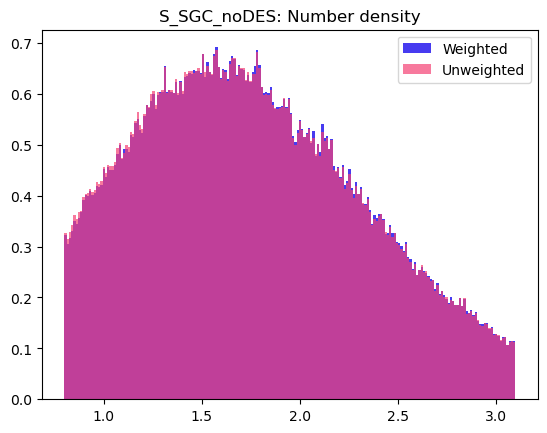

In [20]:
plt.hist(S_SGC_noDES[4], bins=200, weights=S_SGC_noDES[2], label = "Weighted", color = "#473BF0", density = True)
plt.hist(S_SGC_noDES[4], bins=200, label = "Unweighted", color = "#F44174",alpha=0.7, density=True)
plt.title("S_SGC_noDES: Number density")
plt.legend();

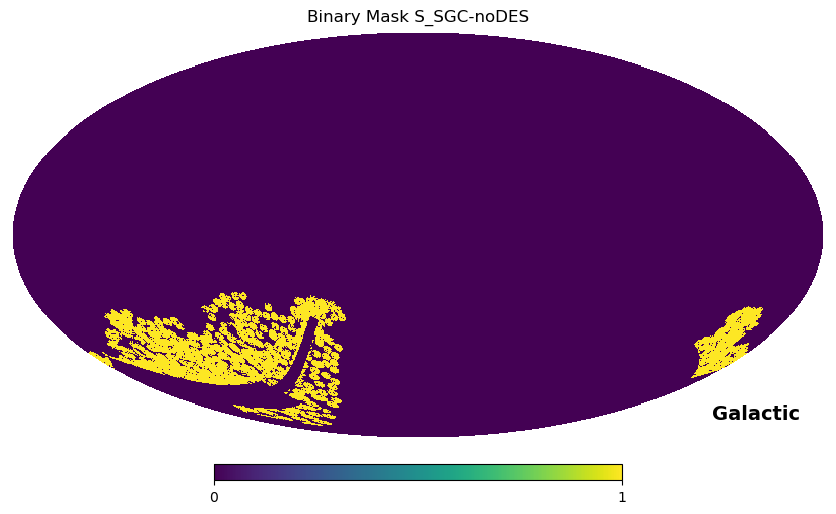

In [22]:
file = 'QSO_maps/QSO_z0.80_3.10_S_SGC-noDES__HPmapcut_default_addLIN_nside2048_v1.5_comp0.00_galactic_BINARY_MASK.fits'
bin_S_SGC_noDES = hp.read_map(file)
hp.mollview(bin_S_SGC_noDES, title='Binary Mask S_SGC-noDES', coord="G")

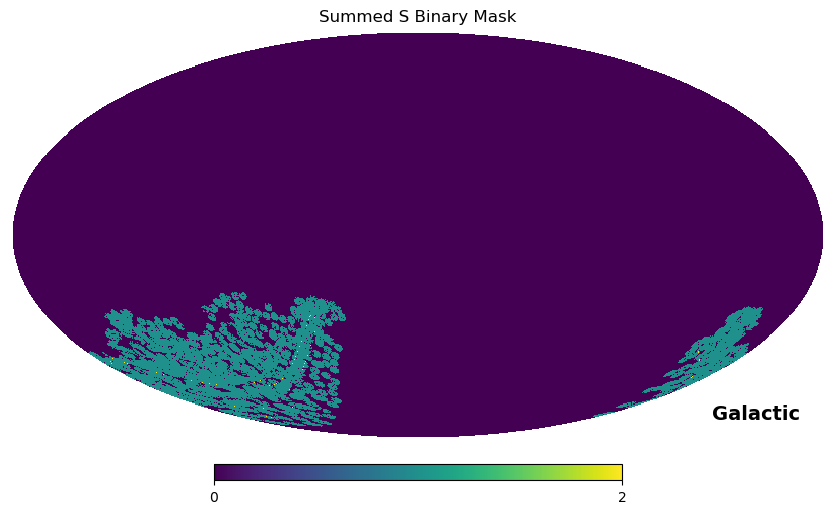

In [26]:
hp.mollview(bin_DES + bin_S_SGC_noDES, title='Summed S Binary Mask', coord="G")